# Interpretable Rule Recommendation with `imodels`

[![nbviewer](https://img.shields.io/badge/nbviewer-orange)](https://nbviewer.org/github/AaronYuen810/rule-reco/blob/master/nb/imodel-rulefit.ipynb)
[![colab](https://img.shields.io/badge/colab-open-blue)](https://colab.research.google.com/github/AaronYuen810/rule-reco/blob/master/nb/imodel-rulefit.ipynb)


In [1]:
%load_ext autoreload
%autoreload 2

# About

This notebook explores using sklearn rulefit to recommend rules for optmizing credit risk management.

In this exploration, we will be using the `imodels` package that implements the RuleFit algorithm.

```
pip install imodels
uv add imodels
```


In [2]:
import json
import pandas as pd
import numpy as np

# Dataset

We will boostrap using public credit card default data from the UCI ML repository (https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients).

Pre requisite:

```
pip install ucimlrepo
```


## Metadata


In [3]:
# pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

# fetch dataset
default_of_credit_card_clients = fetch_ucirepo(id=350)

# metadata
print("Metadata")
print(json.dumps(default_of_credit_card_clients.metadata, indent=4))

# variable information
print("Variable Information")
display(default_of_credit_card_clients.variables)

# variable description
print("Variable Description")
print(default_of_credit_card_clients.metadata["additional_info"]["variable_info"])


Metadata
{
    "uci_id": 350,
    "name": "Default of Credit Card Clients",
    "repository_url": "https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients",
    "data_url": "https://archive.ics.uci.edu/static/public/350/data.csv",
    "abstract": "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.",
    "area": "Business",
    "tasks": [
        "Classification"
    ],
    "characteristics": [
        "Multivariate"
    ],
    "num_instances": 30000,
    "num_features": 23,
    "feature_types": [
        "Integer",
        "Real"
    ],
    "demographics": [
        "Sex",
        "Education Level",
        "Marital Status",
        "Age"
    ],
    "target_col": [
        "Y"
    ],
    "index_col": [
        "ID"
    ],
    "has_missing_values": "no",
    "missing_values_symbol": null,
    "year_of_dataset_creation": 2009,
    "last_updated": "Fri Mar 29 

,name,role,type,demographic,description,units,missing_values
0,ID,ID,Integer,None,None,None,no
1,X1,Feature,Integer,None,LIMIT_BAL,None,no
2,X2,Feature,Integer,Sex,SEX,None,no
3,X3,Feature,Integer,Education Level,EDUCATION,None,no
4,X4,Feature,Integer,Marital Status,MARRIAGE,None,no
5,X5,Feature,Integer,Age,AGE,None,no
6,X6,Feature,Integer,None,PAY_0,None,no
7,X7,Feature,Integer,None,PAY_2,None,no
8,X8,Feature,Integer,None,PAY_3,None,no
9,X9,Feature,Integer,None,PAY_4,None,no


Variable Description
This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
X2: Gender (1 = male; 2 = female).
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
X4: Marital status (1 = married; 2 = single; 3 = others).
X5: Age (year).
X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment dela

## Load Data


In [4]:
# data (as pandas dataframes)
X = default_of_credit_card_clients.data.features
y = default_of_credit_card_clients.data.targets
var_mapper = {}
for _, r in (
    default_of_credit_card_clients.variables[["name", "description"]]
    .dropna()
    .iloc[:-1]
    .iterrows()
):
    name = r["name"]
    var_name = r["description"]
    var_mapper[name] = var_name

## Shuffling & Quick Feature Engineering


In [5]:
# Shuffling data, preparing target and variables
from sklearn.utils import shuffle

rng = np.random.RandomState(1)

data, y = shuffle(np.array(X), y, random_state=rng)
data = pd.DataFrame(data, columns=X.columns).rename(columns=var_mapper)

for col in ["ID"]:
    if col in data.columns:
        del data[col]

# Quick feature engineering
data = data.rename(columns={"PAY_0": "PAY_1"})
old_PAY = ["PAY_3", "PAY_4", "PAY_5", "PAY_6"]
data["PAY_old_mean"] = data[old_PAY].apply(lambda x: np.mean(x), axis=1)

old_BILL_AMT = ["BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]
data["BILL_AMT_old_mean"] = data[old_BILL_AMT].apply(lambda x: np.mean(x), axis=1)
data["BILL_AMT_old_std"] = data[old_BILL_AMT].apply(lambda x: np.std(x), axis=1)

old_PAY_AMT = ["PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
data["PAY_AMT_old_mean"] = data[old_PAY_AMT].apply(lambda x: np.mean(x), axis=1)
data["PAY_AMT_old_std"] = data[old_PAY_AMT].apply(lambda x: np.std(x), axis=1)

data.drop(old_PAY_AMT + old_BILL_AMT + old_PAY, axis=1, inplace=True)

# Creating the train/test split
feature_names = list(data.columns)
print("List of variables used to train models : " + str(feature_names))
data = data.values
n_samples = data.shape[0]
n_samples_train = int(n_samples / 2)
y_train = y[:n_samples_train]
y_test = y[n_samples_train:]
X_train = data[:n_samples_train]
X_test = data[n_samples_train:]

List of variables used to train models : ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2', 'BILL_AMT1', 'BILL_AMT2', 'PAY_AMT1', 'PAY_AMT2', 'PAY_old_mean', 'BILL_AMT_old_mean', 'BILL_AMT_old_std', 'PAY_AMT_old_mean', 'PAY_AMT_old_std']


# RuleFit


In [6]:
from imodels import RuleFitClassifier


In [7]:
# fit a rulefit model
rulefit = RuleFitClassifier(max_rules=10)
rulefit.fit(X_train, y_train, feature_names=feature_names)

rulefit

/home/aaron/projects/klika2c/rule-reco/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,n_estimators,100
,tree_size,4
,sample_fract,'default'
,max_rules,10
,memory_par,0.01
,tree_generator,None
,lin_trim_quantile,0.025
,lin_standardise,True
,exp_rand_tree_size,True
,include_linear,True
,alpha,None


In [8]:
from sklearn import metrics

def evaluation_report(model, X_test, y_test):
    """Helper:
    Generate common classification performance metrics.

    Pass in a fitted classifier `model`.
    """

    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]
    print("Test AUROC:", metrics.roc_auc_score(y_test, proba))
    print("Test AUPRC:", metrics.average_precision_score(y_test, proba))
    print("Report:", metrics.classification_report(y_test, preds))

In [9]:
evaluation_report(rulefit, X_test, y_test)

Test AUROC: 0.7539459353724256
Test AUPRC: 0.5075500002403979
Report:               precision    recall  f1-score   support

           0       0.78      1.00      0.88     11727
           1       0.00      0.00      0.00      3273

    accuracy                           0.78     15000
   macro avg       0.39      0.50      0.44     15000
weighted avg       0.61      0.78      0.69     15000



/home/aaron/projects/klika2c/rule-reco/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/aaron/projects/klika2c/rule-reco/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/aaron/projects/klika2c/rule-reco/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

In [10]:
# inspect and print the rules
print("Rulefit has an alternative visualization:")
rules = rulefit._get_rules()
rules = rules[rules.coef != 0].sort_values("support", ascending=False)
# 'rule' is how the feature is constructed
# 'coef' is its weight in the final linear model
# 'support' is the fraction of points it applies to
display(rules[["rule", "coef", "support"]].style.background_gradient(cmap="viridis"))

Rulefit has an alternative visualization:


,rule,coef,support
1,SEX,-0.066095,1.000000
24,PAY_old_mean <= 0.625 and PAY_1 <= 1.5,-0.162772,0.836467
22,PAY_1 <= 1.5 and PAY_2 <= 1.0,-0.196698,0.822200
20,PAY_1 <= 1.5 and PAY_2 <= 1.5,-0.165528,0.822200
18,PAY_old_mean <= 0.875 and PAY_1 <= 1.5 and PAY_2 <= 1.5,-0.178880,0.793667
23,LIMIT_BAL > 25000.0 and PAY_old_mean <= 0.875 and PAY_1 <= 1.5,-0.151214,0.779733
21,BILL_AMT_old_mean > 594.375 and PAY_1 <= 1.5,-0.007808,0.774467
17,PAY_1 <= 0.5,-0.151982,0.772800
16,PAY_old_mean <= 0.375 and BILL_AMT_old_std > 25.33124 and PAY_1 <= 1.5,-0.220287,0.705400
19,PAY_old_mean <= 0.125 and PAY_1 <= 1.5 and BILL_AMT1 > 53.5,-0.016849,0.683267


In [11]:
rules

,rule,type,coef,support,importance
1,SEX,linear,-0.066095,1.000000,0.032289
24,PAY_old_mean <= 0.625 and PAY_1 <= 1.5,rule,-0.162772,0.836467,0.060201
22,PAY_1 <= 1.5 and PAY_2 <= 1.0,rule,-0.196698,0.822200,0.075206
20,PAY_1 <= 1.5 and PAY_2 <= 1.5,rule,-0.165528,0.822200,0.063289
18,PAY_old_mean <= 0.875 and PAY_1 <= 1.5 and PAY_2 <= 1.5,rule,-0.178880,0.793667,0.072388
23,LIMIT_BAL > 25000.0 and PAY_old_mean <= 0.875 and PAY_1 <= 1.5,rule,-0.151214,0.779733,0.062667
21,BILL_AMT_old_mean > 594.375 and PAY_1 <= 1.5,rule,-0.007808,0.774467,0.003263
17,PAY_1 <= 0.5,rule,-0.151982,0.772800,0.063684
16,PAY_old_mean <= 0.375 and BILL_AMT_old_std > 25.33124 and PAY_1 <= 1.5,rule,-0.220287,0.705400,0.100421
19,PAY_old_mean <= 0.125 and PAY_1 <= 1.5 and BILL_AMT1 > 53.5,rule,-0.016849,0.683267,0.007838


# Skope-rules

Similar in terms of model output, Skope-rules outputs a ruleset. 

RuleFit and SkopeRules differ only in the way they prune rules: RuleFit uses a linear model whereas SkopeRules heuristically deduplicates rules sharing overlap.

In [12]:
from imodels import SkopeRulesClassifier

# Fit the model
skoperules = SkopeRulesClassifier(max_features=4)
skoperules.fit(X_train, y_train.to_numpy().ravel(), feature_names=feature_names)

# Evaluate performance
evaluation_report(skoperules, X_test, y_test)


Test AUROC: 0.7115812840710541
Test AUPRC: 0.4663176973458867
Report:               precision    recall  f1-score   support

           0       0.78      1.00      0.88     11727
           1       0.00      0.00      0.00      3273

    accuracy                           0.78     15000
   macro avg       0.39      0.50      0.44     15000
weighted avg       0.61      0.78      0.69     15000



/home/aaron/projects/klika2c/rule-reco/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/aaron/projects/klika2c/rule-reco/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/aaron/projects/klika2c/rule-reco/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

In [13]:
# get rules, arranged according to precision

print("The top 5 most precise rules are:")
for rule in skoperules.rules_[:5]:
    print("-\t", rule)
    

The top 5 most precise rules are:
-	 EDUCATION <= 4.5 and PAY_1 > 1.5 and PAY_AMT_old_std <= 7690.39526
-	 BILL_AMT_old_std <= 10796.61523 and PAY_1 > 1.5 and PAY_AMT_old_std <= 3406.88074
-	 BILL_AMT1 > 410.0 and PAY_2 > 1.5 and PAY_old_mean > 0.625
-	 BILL_AMT2 <= 61377.0 and BILL_AMT_old_mean <= 41695.5 and PAY_2 > 1.5
-	 BILL_AMT_old_std <= 4028.8916 and PAY_AMT_old_mean > 4.875 and PAY_old_mean > 0.625


# FIGS
- Gives you the ability to limit complexity explicitly (number of rules / splits) → helpful for interpretability.
- Likely more stable thresholds, because fewer splits / simpler structure.
- Easier to explain to domain experts, possibly more robust to small changes.

The only downside is the lack of rule set output.

## Simple FIGS with 4 splits

This model is extremely interpretable by restricting the split to 4.  A physician can now (i) easily make predictions using the 4 relevant features and (ii) vet the model to ensure it matches their domain expertise.

In [14]:
from imodels import FIGSClassifier

# Fit the model
figs = FIGSClassifier(max_rules=4) # initialize FIGS
figs.fit(X_train, y_train) # fit model

display(figs)

evaluation_report(figs, X_test, y_test)# Eval performance


,max_rules,4
,max_trees,None
,min_impurity_decrease,0.0
,random_state,None
,max_features,None
,max_depth,None


Test AUROC: 0.7481067464364136
Test AUPRC: 0.4941465341254959
Report:               precision    recall  f1-score   support

           0       0.85      0.93      0.89     11727
           1       0.64      0.43      0.51      3273

    accuracy                           0.82     15000
   macro avg       0.74      0.68      0.70     15000
weighted avg       0.81      0.82      0.81     15000



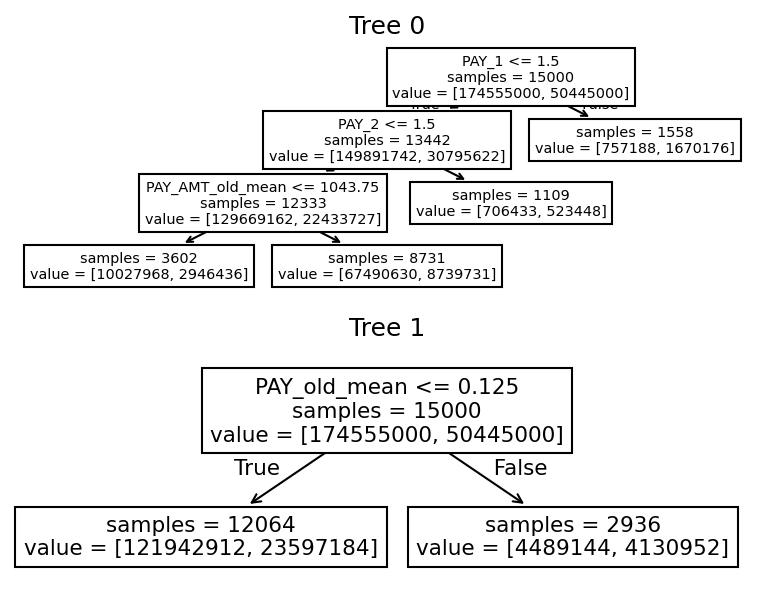

In [15]:
figs.plot(feature_names=feature_names)

## Flexible FIGS
If we want a more flexible model, we can also remove the constraint on the number of rules. This enables the model to model after more complex patterns.

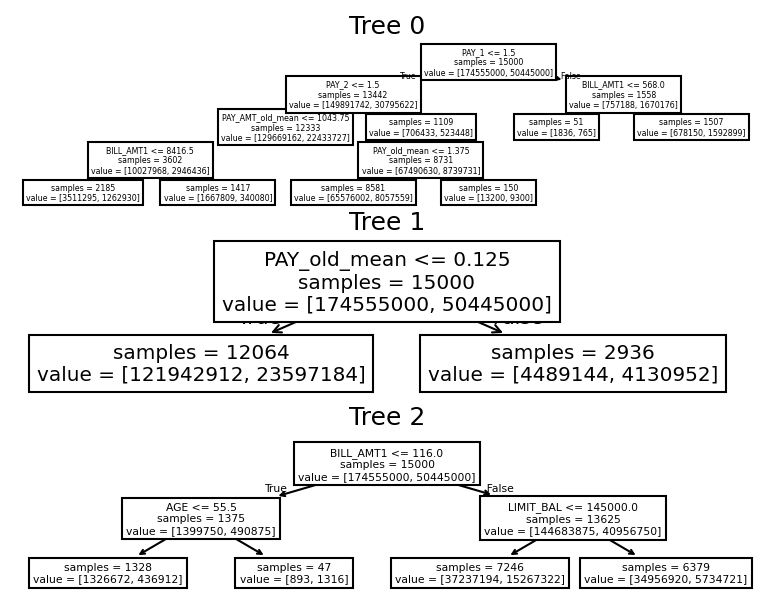

Test AUROC: 0.7646124320656688
Test AUPRC: 0.5229413690705917
Report:               precision    recall  f1-score   support

           0       0.85      0.94      0.89     11727
           1       0.64      0.41      0.50      3273

    accuracy                           0.82     15000
   macro avg       0.75      0.67      0.70     15000
weighted avg       0.80      0.82      0.81     15000



In [16]:
from sklearn import clone

# clone from figs
figs_flexi = clone(figs)
figs_flexi.set_params(max_rules=10) # remove split constraint

figs_flexi.fit(X_train, y_train) # fit model

figs_flexi.plot(feature_names=feature_names) # plot all FIG trees

# Eval performance
evaluation_report(figs_flexi, X_test, y_test)

